## Урок 3

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.use('seaborn-ticks')
plt.rcParams.update({'font.size': 14})

### Задание 1

Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log (как вариант - использовать np.clip или np.where).

In [28]:
y_true = 1
y_pred = 1

<i>Исходный код:

In [7]:
def calc_logloss(y, y_pred):
    err = np.mean(- y * np.log(y_pred) - (1.0 - y) * np.log(1.0 - y_pred))
    return err

In [29]:
calc_logloss(y_true, y_pred)

<ipython-input-7-eda2dfa4429d>:2: RuntimeWarning: divide by zero encountered in log
  err = np.mean(- y * np.log(y_pred) - (1.0 - y) * np.log(1.0 - y_pred))
<ipython-input-7-eda2dfa4429d>:2: RuntimeWarning: invalid value encountered in double_scalars
  err = np.mean(- y * np.log(y_pred) - (1.0 - y) * np.log(1.0 - y_pred))


nan

<b>Вариант 1 с использованием np.clip

In [23]:
def calc_logloss_corr1(y, y_pred):
    y_pred = np.clip(y_pred, 1e-8, 0.99)
    err = np.mean(- y * np.log(y_pred) - (1.0 - y) * np.log(1.0 - y_pred))
    return err

In [30]:
calc_logloss_corr1(y_true, y_pred)

0.01005033585350145

<b> Вариант 2 с использованием np.where

In [31]:
def calc_logloss_corr2(y, y_pred):
    y_pred = np.where((y_pred != 0) & (y_pred != 1) , y_pred + 1e-8, y_pred - 1e-8)
    err = np.mean(- y * np.log(y_pred) - (1.0 - y) * np.log(1.0 - y_pred))
    return err

In [32]:
calc_logloss_corr1(y_true, y_pred)

0.01005033585350145

### Задание 2

Подберите аргументы функции eval_LR_model для логистической регрессии таким образом, чтобы log loss был минимальным. Покажите влияние гиперпараметров на ошибку алгоритма (оптимально здесь использовать критерий остановки обучения).

In [34]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],  # стаж репетитора
              [500, 700, 750, 600, 1450,        # средняя стоимость занятия
               800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]],  # квалификация репетитора
              dtype = np.float64).T 

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1]) # поступил или нет ученик на специальность Математика
X

array([[1.00e+00, 1.00e+00, 5.00e+02, 1.00e+00],
       [1.00e+00, 1.00e+00, 7.00e+02, 1.00e+00],
       [1.00e+00, 2.00e+00, 7.50e+02, 2.00e+00],
       [1.00e+00, 1.00e+00, 6.00e+02, 1.00e+00],
       [1.00e+00, 3.00e+00, 1.45e+03, 2.00e+00],
       [1.00e+00, 0.00e+00, 8.00e+02, 1.00e+00],
       [1.00e+00, 5.00e+00, 1.50e+03, 3.00e+00],
       [1.00e+00, 1.00e+01, 2.00e+03, 3.00e+00],
       [1.00e+00, 1.00e+00, 4.50e+02, 1.00e+00],
       [1.00e+00, 2.00e+00, 1.00e+03, 2.00e+00]])

In [35]:
def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

In [38]:
def standard_scaler(x):
    res = (x - x.mean()) / x.std()
    return res

X_st = X.copy()
X_st[:, 2] = standard_scaler(X[:, 2])
X_st[:, 2]

array([-0.97958969, -0.56713087, -0.46401617, -0.77336028,  0.97958969,
       -0.36090146,  1.08270439,  2.11385144, -1.08270439,  0.05155735])

В начале я сразу сделала функцию с остановом (она будет ниже) и запустила ее для поиска минимума с разницей между ошибками = 0. Но комп, выполняя ее завис и очень долго не отвисал. Поэтому я решила попробовать ручками проверить, где же этот минимум. Внизу результат этой попытки - я так и не смогла найти минимум, даже при скорости обучения = 1 и количестве итераций 10000000 (10 миллионов!!!) У меня комп час это считал... Я не стала удалять час его работы. Поэтому в начале идет просто расчет на 10 млн итераций, а затем идет функция с остановом. 

<font color = red><b>Вопрос. Может ли скорость обучения быть больше 1? Почему спрашиваю - я пыталась, но он мне выдает ошибку. Там сигмоида глючить начинает. А я плохо понимаю, почему и можно ли это устранить.

In [129]:
def eval_LR_model(X, y, iterations, alpha=1e-4):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        z = np.dot(X, w) # log(p/(1-p))
        y_pred = sigmoid(z) # p [0, 1]
        err = calc_logloss_corr1(y, y_pred)
        w -= alpha * (1/n * np.dot(X.T, (y_pred - y)))
        if i % (iterations / 10) == 0:
            print(i, w, err)
    return w

In [ ]:
# eval_LR_model(X_st, y, 10000000, alpha=1)

#1000000 [-221.24481653  -15.61815226  -65.53914787  169.31528456] 0.010758997790231817
#2000000 [-265.99490783  -18.40695373  -79.10854685  202.86158867] 0.007396237992366236
#3000000 [-292.27559167  -20.04677984  -87.0756784   222.56663373] 0.006265322782887842
#4000000 [-310.91441506  -21.21034925  -92.72561605  236.5430201 ] 0.005896043390808234
#5000000 [-325.35881844  -22.11231177  -97.1038909   247.3746871 ] 0.005720640758645177
#6000000 [-337.15033713  -22.84874089 -100.67793151  256.21723779] 0.005603919437892747
#7000000 [-347.11212541  -23.47096699 -103.69731063  263.68780289] 0.005520681121795744
#8000000 [-355.73556611  -24.00964319 -106.31100052  270.15480216] 0.005458339030482178
#9000000 [-363.33751208  -24.48454043 -108.61505648  275.85581008] 0.00540990884457914
#10000000 [-370.13420747  -24.90915457 -110.67503139  280.95297077] 0.00537120502775594
#array([-370.13420747,  -24.90915457, -110.67503139,  280.95297077])

In [125]:
def eval_LR_model_min(X, y, stop_diff=0.001, max_iter = np.inf, alpha=1):
    iter_num = 0
    err_prev = 0
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    while True:
        z = np.dot(X, w) # log(p/(1-p))
        y_pred = sigmoid(z) # p [0, 1]
        err = calc_logloss_corr1(y, y_pred)
        w -= alpha * (1/n * np.dot(X.T, (y_pred - y)))
        iter_num = iter_num + 1
        if np.abs(err - err_prev) < stop_diff:
            print('Stop:', iter_num, w, err)
            break
        else:
            err_prev = err
    return w, err, iter_num 

In [205]:
w, err, iter_num = eval_LR_model_min(X_st, y, stop_diff=0.000001, max_iter = np.inf, alpha=1)
w, err, iter_num

Stop: 28437 [-55.02749909  -5.17882895 -15.17446128  44.55808902] 0.08409225876674077


(array([-55.02749909,  -5.17882895, -15.17446128,  44.55808902]),
 0.08409225876674077,
 28437)

На 28437 итерации разница между ошибками меньше 0.000001

<b>Влияние гиперпараметров на ошибку алгоритма.

In [164]:
df = pd.DataFrame(columns=['alpha', 'iter', 'w1', 'w2', 'w3', 'w4', 'Err'])

def eval_LR_model_corr(X, y, iterations, alpha=1e-4):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        z = np.dot(X, w) # log(p/(1-p))
        y_pred = sigmoid(z) # p [0, 1]
        err = calc_logloss_corr1(y, y_pred)
        w -= alpha * (1/n * np.dot(X.T, (y_pred - y)))
        if i % 200 == 0:
            w1, w2, w3, w4 = w
            df.loc[len(df)] = [alpha, i, w1, w2, w3, w4, err]
    return w, df

In [165]:
for alpha in np.logspace(-4, -2, 5):
    eval_LR_model_corr(X_st, y, 2000, alpha)

In [183]:
alpha_list = list(set(df['alpha']))
alpha_list.sort()
alpha_list

[0.0001, 0.00031622776601683794, 0.001, 0.0031622776601683794, 0.01]

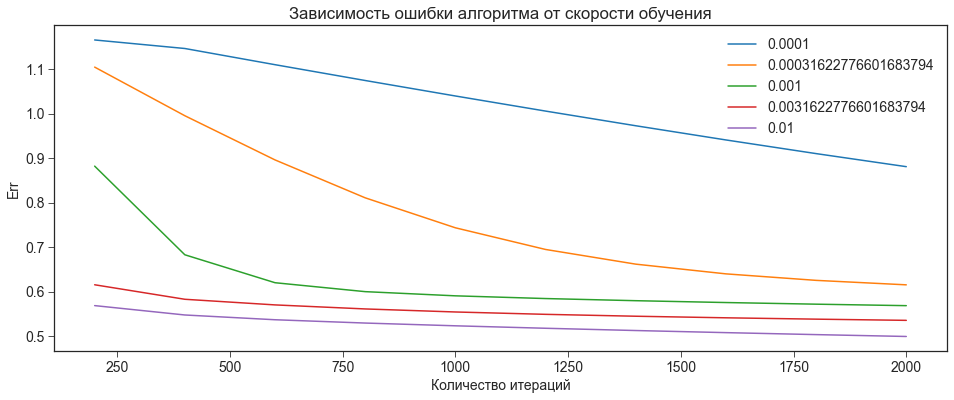

In [185]:
fig, ax = plt.subplots(figsize=(16,6)) 


plt.title('Зависимость ошибки алгоритма от скорости обучения')

for i in range(len(alpha_list)):
    ax.plot(df['iter'].loc[(df['alpha']==alpha_list[i])], df['Err'].loc[(df['alpha']==alpha_list[i])], label = alpha_list[i]) 
ax.set_xlabel('Количество итераций')
ax.set_ylabel('Err')
plt.legend(loc=1)
plt.show()

### Задание 3

In [208]:
w

array([-55.02749909,  -5.17882895, -15.17446128,  44.55808902])

Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются значения признаков Х и веса, которые уже посчитаны функцией eval_LR_model, на выходе - массив y_pred_proba).

In [209]:
def calc_pred_proba(X, w):
    z = np.dot(X, w)
    y_pred_proba = sigmoid(z).round(2)
    return y_pred_proba

In [210]:
calc_pred_proba(X_st, w)

array([0.31, 0.  , 1.  , 0.02, 0.98, 0.01, 1.  , 0.01, 0.69, 1.  ])

### Задание 4

Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются значения признаков Х и веса, которые уже посчитаны функцией eval_LR_model, на выходе - массив y_pred).

In [254]:
def calc_pred(X, y):
    y_pred_proba = calc_pred_proba(X, w)
    y_pred = np.where(y_pred_proba <= 0.7, 0, 1)
    return y_pred

<font color='red'><b>Я сделала критерий отнесения к классу 0.7, а не 0.5, как было сказано на лекции, так как иначе получается полное совпадение предсказанных значений с истинными. Не интересно.

In [255]:
y_pred = calc_pred(X_st, y)
y_pred

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

### Задание 5 

Посчитайте accuracy, матрицу ошибок, precision и recall, а также F1-score.

<b> Матрица ошибок

На лекции было сказано не использовать цикл for. Я не смогла найти каким методом можно сравнив две матрицы создать третью. И не смогла придумать, можно ли как-то для этого приспособить np.where. Поэтому делаю через создание датафрейма и агрегирование. Ничего лучше придумать не смогла.

In [256]:
err_matrix_df = pd.DataFrame(columns=['y_true', 'y_pred', 'res'])
err_matrix_df['y_true'] = y
err_matrix_df['y_pred'] = y_pred
err_matrix_df['res'] = err_matrix_df['y_true'].astype(str) + err_matrix_df['y_pred'].astype(str)
err_matrix_df   

,y_true,y_pred,res
0,0,0,00
1,0,0,00
2,1,1,11
3,0,0,00
4,1,1,11
5,0,0,00
6,1,1,11
7,0,0,00
8,1,0,10
9,1,1,11


In [257]:
err_matrix_df['res'].value_counts()

00    5
11    4
10    1
Name: res, dtype: int64

In [264]:
TN = err_matrix_df['res'].loc[(err_matrix_df['res'] == '00')].value_counts()
TN

00    5
Name: res, dtype: int64

In [265]:
TP = err_matrix_df['res'].loc[(err_matrix_df['res'] == '11')].value_counts()
TP

11    4
Name: res, dtype: int64

In [266]:
FP = err_matrix_df['res'].loc[(err_matrix_df['res'] == '01')].value_counts()
FP

Series([], Name: res, dtype: int64)

In [267]:
FP = err_matrix_df['res'].loc[(err_matrix_df['res'] == '11')].value_counts()
FP

11    4
Name: res, dtype: int64

### Задание 6

Могла ли модель переобучиться? Почему?

<i>Если честно, я не очень поняла, на основании каких данных можно ответить на данный вопрос. Но интуитивно, мне кажется, что наша модель переобучиться не могла. Так как для того, чтобы переобучиться, нужно очень хорошо настроиться именно на конкретные данные. А у нас их так мало, что модель в принципе не может ни на что настроиться.

### Задание 7

Создайте функции eval_LR_model_l1 и eval_LR_model_l2 с применением L1 и L2 регуляризации соответственно.

In [259]:
def eval_LR_model_l2(X, y, iterations, alpha=1e-4, lambda_=1e-8):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        z = np.dot(X, w) # log(p/(1-p))
        y_pred = sigmoid(z) # p [0, 1]
        err = calc_logloss_corr1(y, y_pred)
        w -= alpha * ((1/n * np.dot(X.T, (y_pred - y))) + 2 * lambda_ * w)
        if i % (iterations / 10) == 0:
            print(i, w, err)
    return w

In [268]:
def eval_LR_model_l1(X, y, iterations, alpha=1e-4, lambda_=1e-8):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        z = np.dot(X, w) # log(p/(1-p))
        y_pred = sigmoid(z) # p [0, 1]
        err = calc_logloss_corr1(y, y_pred)
        w -= alpha * ((1/n * np.dot(X.T, (y_pred - y))) + lambda_ * np.sign(w))
        if i % (iterations / 10) == 0:
            print(i, w, err)
    return w